The GPT counterpart for LSTM.
Note that here it should be batch first while in LSTM, we use len_seq first

convert PSD to dB

In [1]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.functional import F
from easydict import EasyDict as edict
from torch.optim.lr_scheduler import ExponentialLR
plt.style.use(FIG_ROOT/"base.mplstyle")

In [3]:
import importlib
import models.gpt
importlib.reload(models.gpt)

<module 'models.gpt' from '/data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/models/gpt.py'>

In [4]:
from models.gpt import myNet
from models.loss import cos_simi_loss, weighted_mse_loss
from models.model_utils import generate_position_encode
from utils.reparam import theta2raw_torch, raw2theta_torch, raw2theta_np
from spectrome import Brain
from sgm.sgm import SGM
from utils.misc import save_pkl, save_pkl_dict2folder, load_pkl, load_pkl_folder2dict, delta_time
from utils.standardize import std_mat, std_vec

In [5]:
torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
else:
    torch.set_default_tensor_type(torch.DoubleTensor)

# Data

In [6]:
import netCDF4
fils = list(DATA_ROOT.glob("*s100tp.nc"))
file2read = netCDF4.Dataset(fils[0], 'r')
psd_all = np.array(file2read.variables["__xarray_dataarray_variable__"][:])
psd_all = 20 * np.log10(psd_all) # to dB
time_points = np.array(file2read.variables["timepoints"][:])
freqs = np.array(file2read.variables["frequencies"][:])


ROIs_order = np.array(file2read.variables["regionx"][:])
file2read.close()

In [7]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [8]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs

# Config

In [9]:
trained_model = load_pkl_folder2dict(RES_ROOT/"SGM_net_large", excluding=['opt*'])
sgm_net = trained_model.model;

Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/freqs.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/loss.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/loss_test.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/model.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/SGM_net_large/paras.pkl


In [27]:
def batch_corr_fn(X_raw, X_pred):
    """Calculate pearons'r in batch
        X_raw: num_p x len_vec
        X_pred: num_p x len_vec
    """
    X_raw_mean = X_raw.mean(axis=-1, keepdims=True)
    X_raw_std = X_raw.std(axis=-1, keepdims=True)
    X_pred_mean = X_pred.mean(axis=-1, keepdims=True)
    X_pred_std = X_pred.std(axis=-1, keepdims=True)
    num = ((X_raw - X_raw_mean)*(X_pred-X_pred_mean)).sum(axis=-1)
    den = torch.sqrt(((X_raw - X_raw_mean)**2).sum(axis=-1)*((X_pred-X_pred_mean)**2).sum(axis=-1))
    corrs = num/den
    return corrs

def evaluate(all_data):
    num_sub, len_seq, _, _ = all_data.shape
    all_data_raw = torch.tensor(all_data)
    all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
    all_data_input = all_data_input.flatten(2);
    
    net.eval()
    sgm_net.eval()
    with torch.no_grad():
        Y_pred = net(all_data_input+pos_enc);
        X_pred = sgm_net(Y_pred.flatten(0, 1));
    corrs = batch_corr_fn(all_data_raw.flatten(0, 1), X_pred);
    corrs = corrs.reshape(num_sub, len_seq, -1)
    return corrs.detach().numpy()

In [53]:
config = edict()
config.nfeature = 39 * 68 # the dim of features at each time point
config.target_dim = 7 # the target dim 
config.ndim = 256 # the output of the first FC layer
config.dropout = 0.0 # the dropout rate
config.n_layer = 2 # the number of self-attention layers
config.n_head = 8 # numher of heads for multi-head attention
config.is_mask = False # Use mask to make the attention causal
config.is_bias = True # Bias  for layernorm
config.block_size = 360 # the preset length of seq, 
config.batch_size = 1 # the batch size
config.k = 1
config.dy_mask = [1, 1, 1, 0, 0, 0, 0] 

paras_train = edict()
paras_train.niter = 1000
paras_train.loss_out = 5
paras_train.eval_out = 20
paras_train.clip = 10 # from 
paras_train.lr_step = 100

#  real data, should be num_sub x len_seq x nrois x nfreqs
all_data = psd_all.transpose(3, 2, 0, 1);

all_data_raw = torch.tensor(all_data)
all_data_input = (all_data_raw - all_data_raw.mean(axis=-1, keepdims=True))/all_data_raw.std(axis=-1, keepdims=True);
all_data_input = all_data_input.flatten(2);

In [56]:
net = myNet(config, 
           prior_bds=torch.tensor(paras.prior_bds));

#loss_fn = nn.MSELoss()
loss_fn = cos_simi_loss
pos_enc = generate_position_encode(config.block_size, config.nfeature).unsqueeze(0)


optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=0.1, verbose=True)

number of parameters: 2.26M
Adjusting learning rate of group 0 to 1.0000e-04.


In [57]:
import time 
from utils.misc import delta_time
# training
loss_cur = 0
losses = []
losses_test = []

t0 = time.time()
sgm_net.eval()
for ix in range(paras_train.niter):
    X_seq = all_data_input 
           
    net.train()
    # Zero the gradients
    optimizer.zero_grad()
    
    theta_pred = net(X_seq+pos_enc)
    X_pred = sgm_net(theta_pred.flatten(0, 1))
    loss = loss_fn(X_seq.flatten(0, 1).reshape(-1, 68, len(paras.freqs)),
                   X_pred)
    
    # Perform backward pass
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(net.parameters(), paras_train.clip)
    # Perform optimization
    optimizer.step()
    
    if ix % paras_train.lr_step == (paras_train.lr_step-1):
        scheduler.step()
        
    loss_cur = loss_cur + loss.item()
    if ix % paras_train.loss_out == (paras_train.loss_out-1):
        losses.append(loss_cur/paras_train.loss_out)
        print(f"At iter {ix+1}/{paras_train.niter}, "
              f"the losses are {loss_cur/paras_train.loss_out:.5f} (train). "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        loss_cur = 0
        net.train()
        t0 = time.time()
    
    if ix % paras_train.eval_out == (paras_train.eval_out-1):
        net.eval()
        loss_test = evaluate(all_data).mean()
        losses_test.append(loss_test)
        print(f"="*100)
        print(f"At iter {ix+1}/{paras_train.niter}, "
              f"the losses on all data are {loss_test:.5f}. "
              f"The time used is {delta_time(t0):.3f}s. "
             )
        print(f"="*100)
        t0 = time.time()

At iter 5/1000, the losses are -0.64717 (train). The time used is 19.737s. 
At iter 10/1000, the losses are -0.68227 (train). The time used is 19.132s. 
At iter 15/1000, the losses are -0.70368 (train). The time used is 19.690s. 
At iter 20/1000, the losses are -0.70753 (train). The time used is 19.222s. 
At iter 20/1000, the losses on all data are 0.71003. The time used is 2.311s. 
At iter 25/1000, the losses are -0.71385 (train). The time used is 19.558s. 
At iter 30/1000, the losses are -0.72623 (train). The time used is 18.878s. 
At iter 35/1000, the losses are -0.76289 (train). The time used is 19.388s. 
At iter 40/1000, the losses are -0.76802 (train). The time used is 19.481s. 
At iter 40/1000, the losses on all data are 0.76827. The time used is 2.646s. 
At iter 45/1000, the losses are -0.76862 (train). The time used is 19.410s. 
At iter 50/1000, the losses are -0.77216 (train). The time used is 18.967s. 
At iter 55/1000, the losses are -0.77461 (train). The time used is 19.647

KeyboardInterrupt: 

In [ ]:
plt.plot(losses)

# Save

In [104]:
trained_model = edict()
trained_model.model = net.cpu()
trained_model.loss_fn = loss_fn
trained_model.optimizer = optimizer
trained_model.paras = paras_train
trained_model.loss = losses
trained_model.config = config
save_pkl_dict2folder(RES_ROOT/f"GPT_simu_net", trained_model, is_force=True)

Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net/model.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net/loss_fn.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net/optimizer.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net/paras.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net/loss.pkl
Save to /data/rajlab1/user_data/jin/MyResearch/TV-SGM/notebooks/../mypkg/../results/GPT_simu_net/config.pkl


# Evaluate

In [105]:
std_fn = lambda x: (x-x.mean(axis=-1, keepdims=True))/x.std(axis=-1, keepdims=True)

<function __main__.<lambda>(x)>

In [107]:
net.eval()
sgm_paramss_est = []
for data_idx  in range(36):
    cur_data = psd_all[:, :, :, data_idx].transpose(2, 0, 1)
    X_test = random_samples_gpt(cur_data,
                                bds=[[0], [360]],
                                theta2raw_fn=None)
    with torch.no_grad():
        Y_pred = net(X_test).squeeze()
        sgm_paramss_est.append(Y_pred.numpy())
sgm_paramss_est = np.array(sgm_paramss_est);

## Parameters

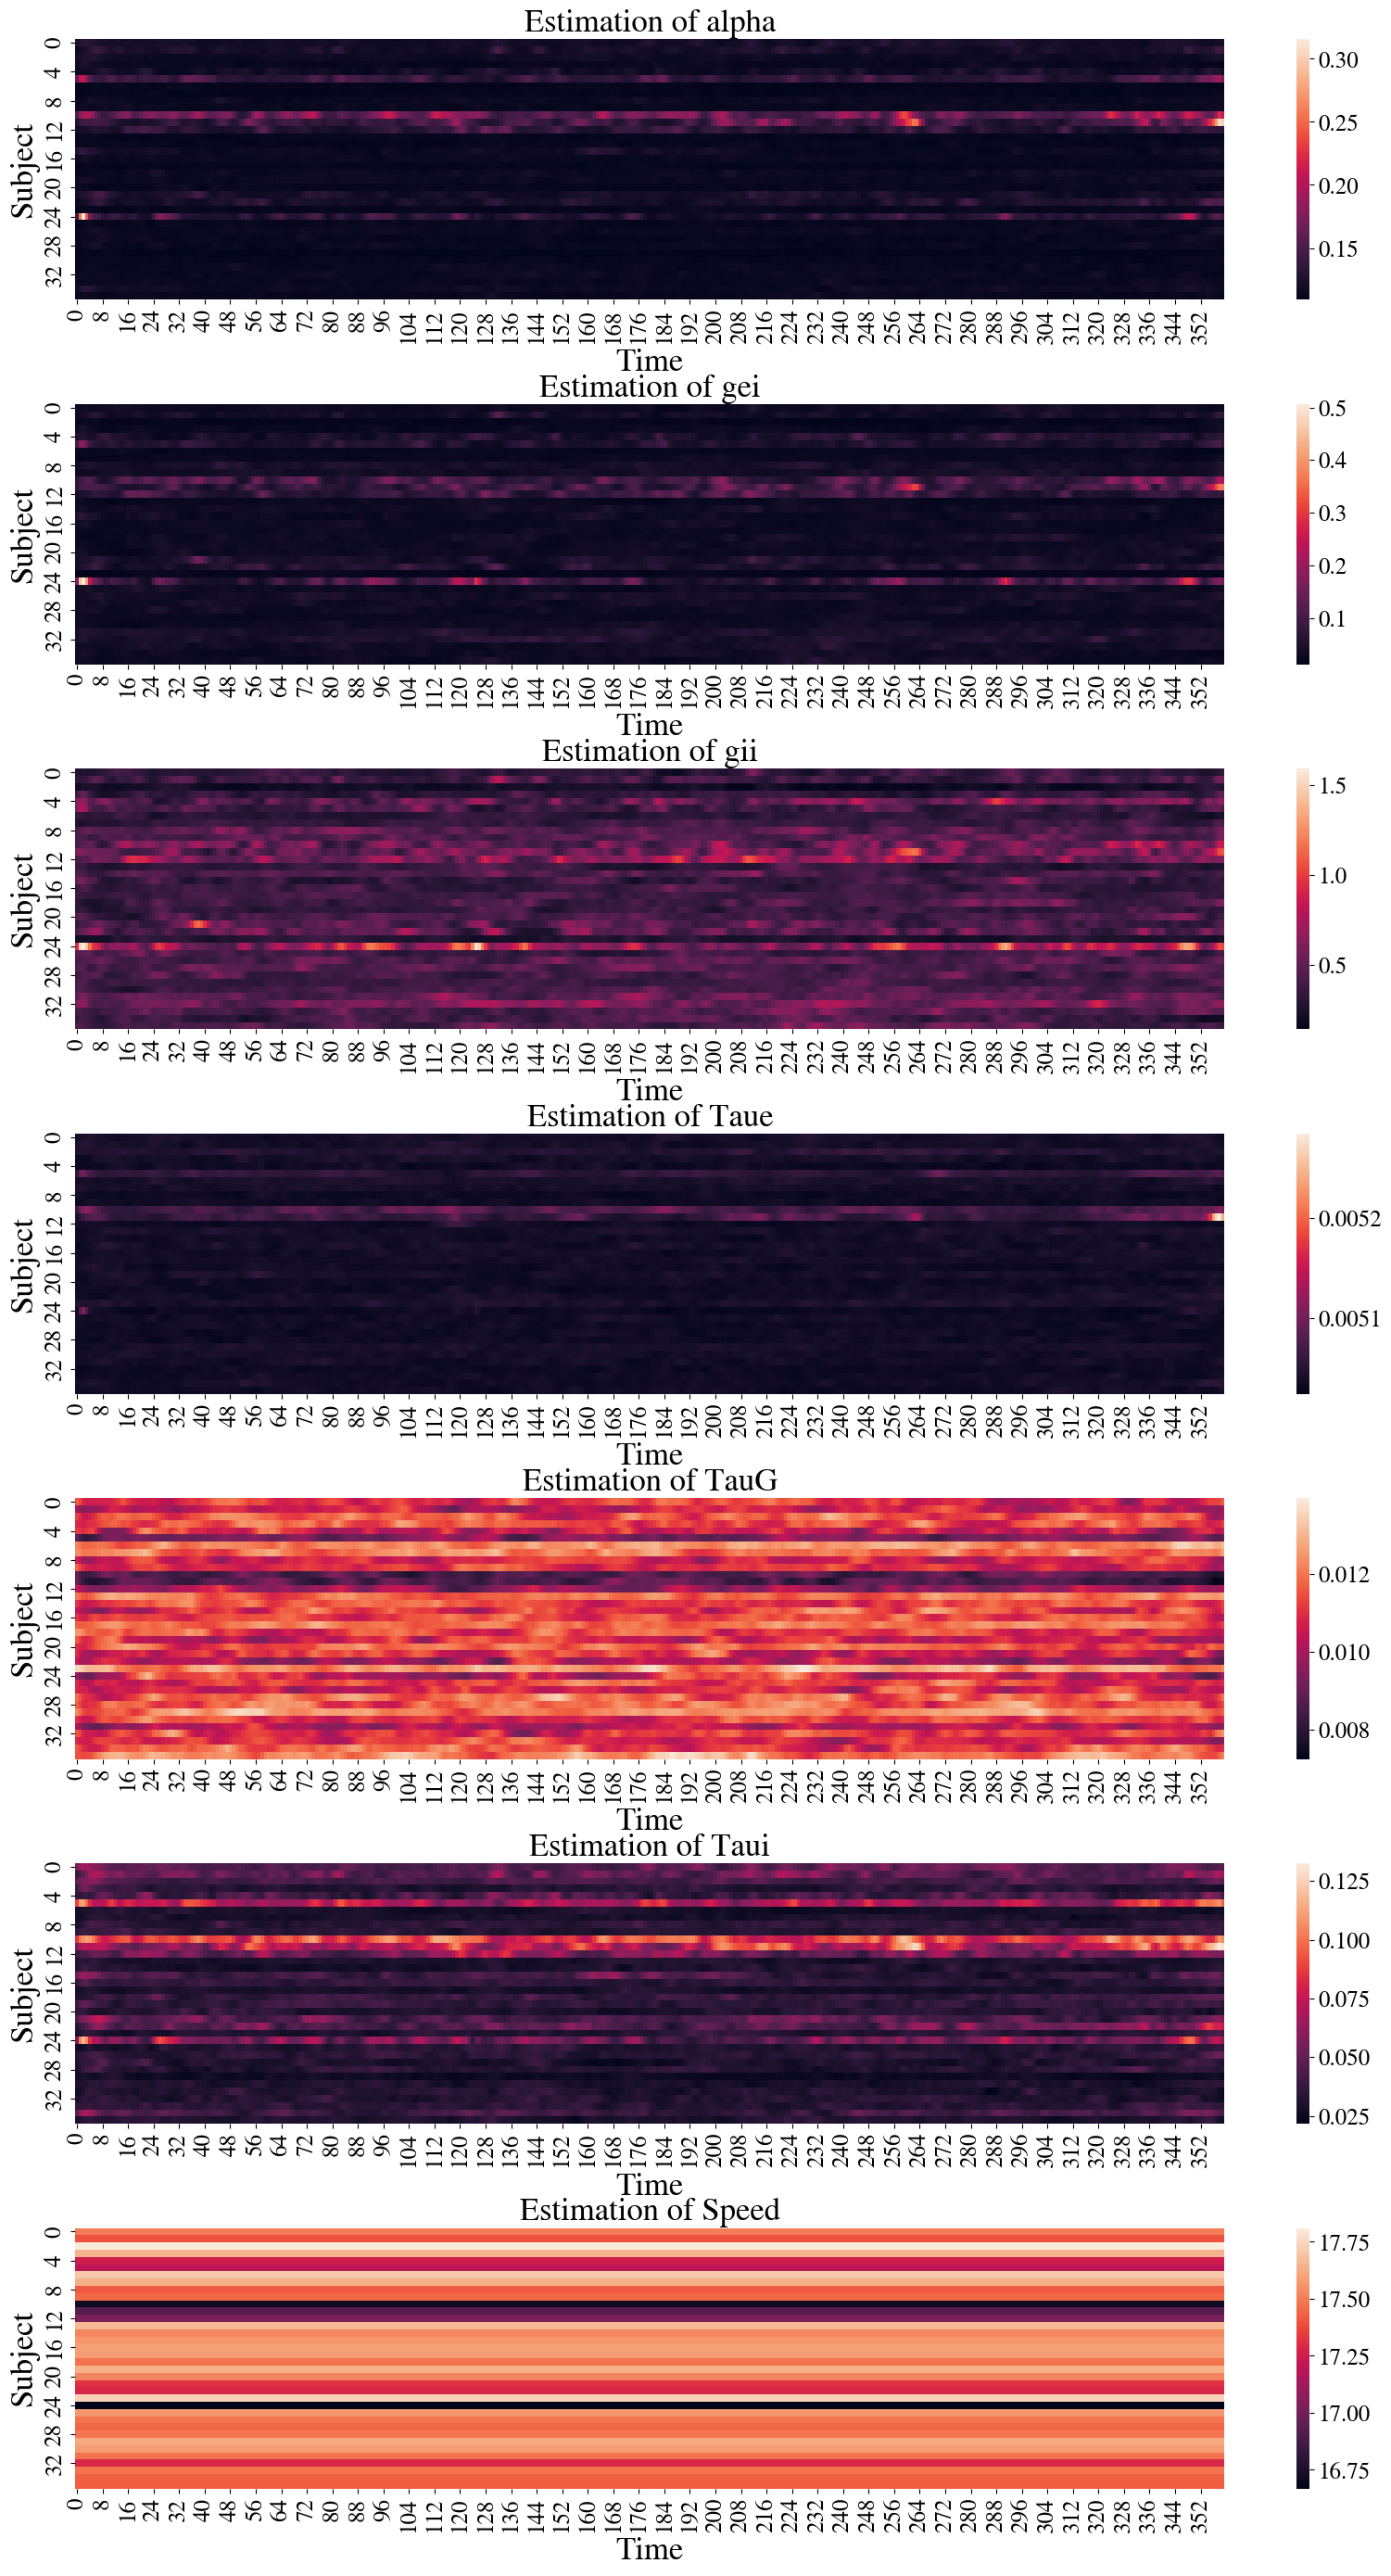

In [109]:
import seaborn as sns
plt.figure(figsize=[20, 35])
for ix in range(7):
    plt.subplot(7, 1, ix+1)
    plt.title(f"Estimation of {paras.names[ix]}", fontsize=25)
    sns.heatmap(sgm_paramss_est[:, :, ix])
    plt.xlabel("Time")
    plt.ylabel("Subject")

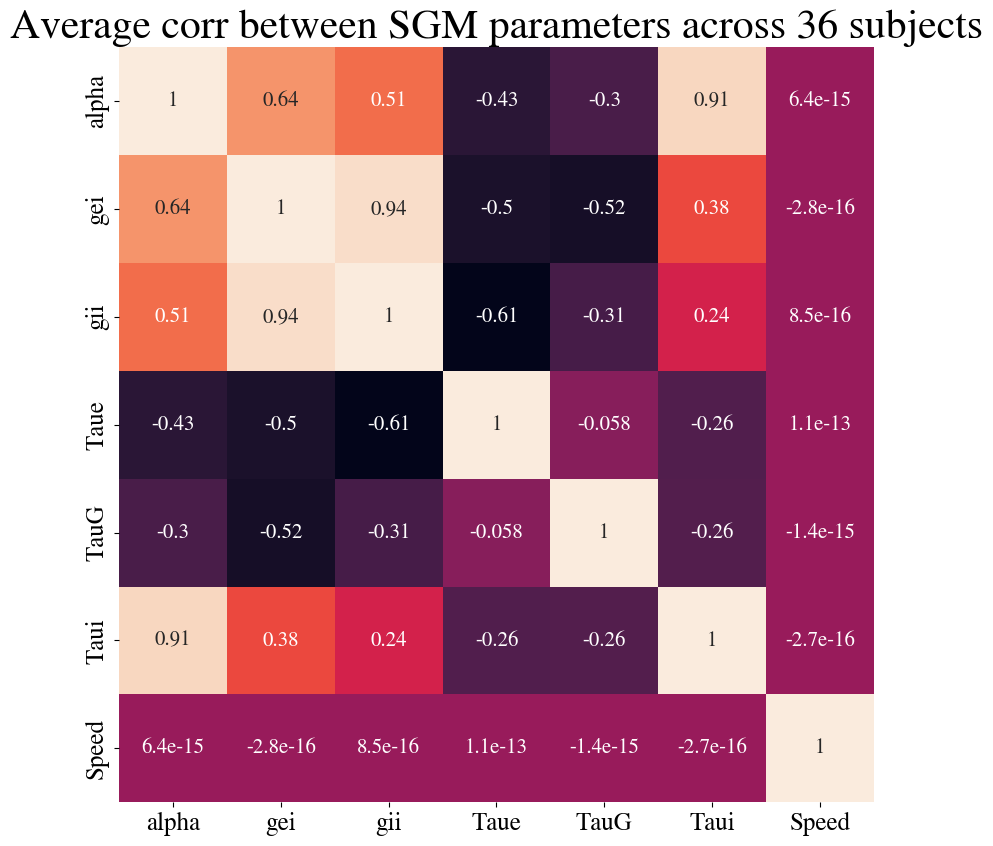

In [110]:
corr_mat = np.array([np.corrcoef(sgm_params_est.T) for sgm_params_est in sgm_paramss_est]).mean(axis=0)
plt.figure(figsize=[10, 10])
plt.title(f"Average corr between SGM parameters across 36 subjects", fontsize=30)
sns.heatmap(corr_mat, square=True, annot=True, cbar=False,
            annot_kws=dict(fontsize=15))
plt.xticks(np.arange(7)+0.5, paras.names)
plt.yticks(np.arange(7)+0.5, paras.names);

### Example

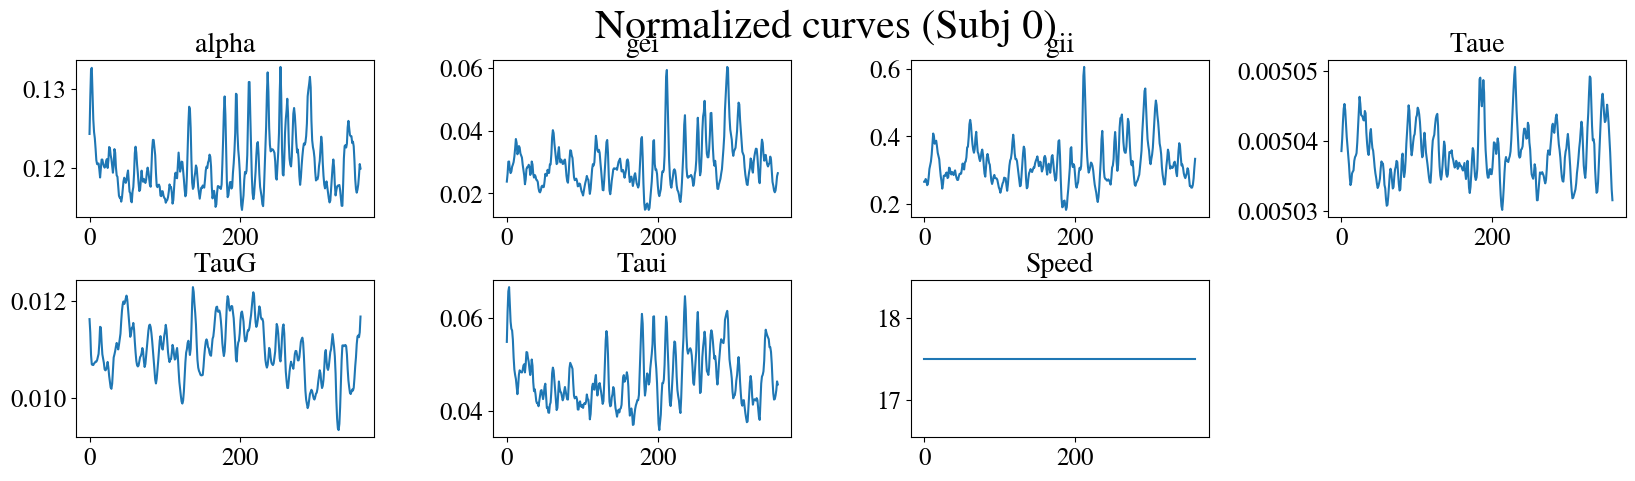

In [111]:
sub_idx = 0
sgm_params_est = sgm_paramss_est[sub_idx]
plt.figure(figsize=[20, 5])
plt.suptitle(f"Normalized curves (Subj {sub_idx})", fontsize=30)
for ix in range(7):
    plt.subplot(2, 4, ix+1)
    plt.plot(sgm_params_est[:, ix])
    plt.title(paras.names[ix], fontsize=20)

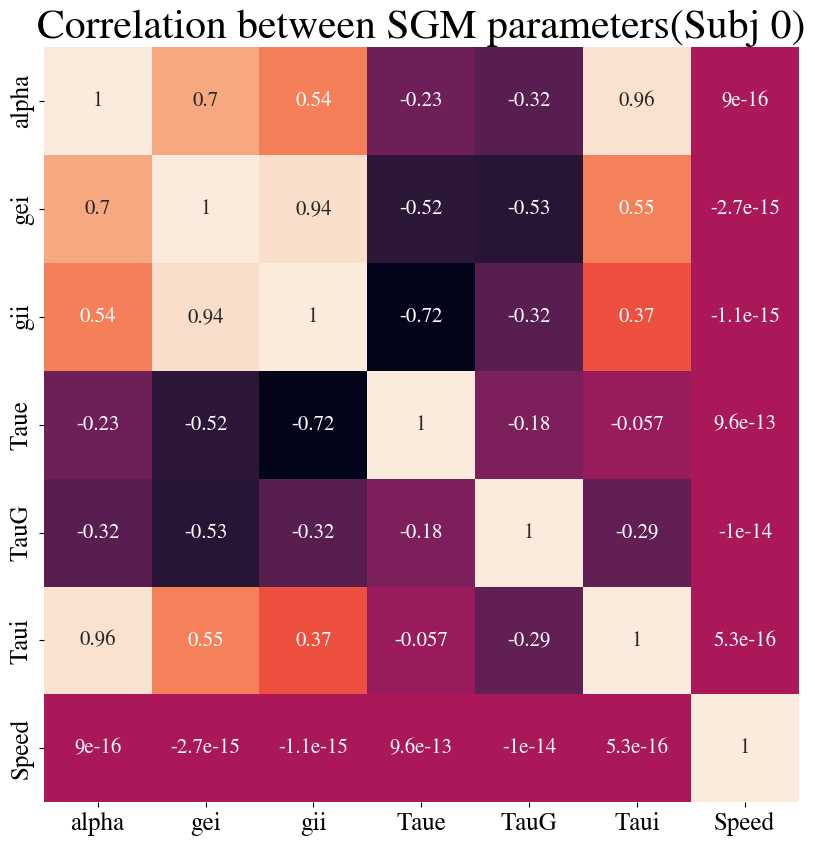

In [112]:
plt.figure(figsize=[10, 10])
plt.title(f"Correlation between SGM parameters(Subj {sub_idx})", fontsize=30)
sns.heatmap(np.corrcoef(sgm_params_est.T), square=True, annot=True, cbar=False,
            annot_kws=dict(fontsize=15))
plt.xticks(np.arange(7)+0.5, paras.names)
plt.yticks(np.arange(7)+0.5, paras.names);